# Using an LLM to automate price extraction and analysis of smartphone data

## Libraries and settings

In [1]:
# Libraries
import re
import io
import sys
import json
import openai
import textwrap
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load OpenAI API key from credentials.json
try:
    with open('./data/credentials.json', encoding='utf-8') as f:
        credentials = json.load(f)
        api_key = credentials['openai']['api_key']
except FileNotFoundError as exc:
    raise ValueError(
        "Please provide OpenAI API key in the credentials.json file.") from exc

# Set up OpenAI API key
openai.api_key = api_key

## Import smartphone data

In [2]:
# Import smartphone data
data = pd.read_csv('./data/smartphone_data.csv', sep=';')

# Display the first few rows
data.head()

,offer_id,dealer_plz,dealer_city,dealer_street_house_nr,make,model,price_raw,camera_resolution_raw,battery_life_raw,storage_size_raw,screen_size_raw,description_raw
0,83197857,6394,Volketswil,Blaserstrasse 19,Apple,iPhone 13,CHF 2518.-,20 MP,16 hrs,256 GB,6.1 IN,"Langlebige Batterie mit Schnellladefunktion, d..."
1,36687537,9532,Oberwil,Furrerstrasse 1,Vivo,Vivo V21,CHF 266.-,12 MP,16 hrs,128 GB,5.8 IN,Modernste Gesichtserkennungstechnologie für Si...
2,66722344,2227,Rüti,Maierstrasse 31,Vivo,Vivo V21,CHF 424.-,12 MP,20 hrs,256 GB,5.8 IN,Ultra-HD-Display für eine atemberaubende Bildq...
3,56164955,5766,Bülach,Sidlerstrasse 6,Google,Pixel 6a,CHF 597.-,12 MP,25 hrs,64 GB,5.8 IN,Mit Stiftunterstützung für Kreativität und Prä...
4,94374605,8304,Belp,Steinerstrasse 8,Google,Pixel 6,CHF 1934.-,20 MP,23 hrs,64 GB,5.8 IN,Aufgeteilt in benutzerfreundliche Kategorien f...


## Functions

### Function to query GPT-3.5 for Python code

In [3]:
# Function to query GPT-3.5 for Python code
def query_gpt(context, question):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a coding assistant. Provide Python code based on user queries."},
                {"role": "user", "content": f"Context: {context}\n\nQuestion: {question}\n\nAlso, provide a short explanation of the result."}
            ],
            temperature=0,
            max_tokens=1500
        )
        full_response = response.choices[0].message['content']

        # Extract code block using regular expression
        code_match = re.search(r'```python(.*?)```', full_response, re.DOTALL)
        if code_match:
            code = code_match.group(1).strip()
            
            # Ensure the plot is saved in the static folder
            code += "\nplt.savefig('./data/graphic.png')\nplt.close()"
            explanation = full_response.split('Explanation:')[1].strip() if 'Explanation:' in full_response else "No explanation provided."
            return code, explanation
        else:
            return "No code block found in the response.", "No explanation provided."
    except Exception as e:
        return f"Error querying GPT: {e}", "No explanation provided."

### Function to query llama 3.2 using Ollama

In [4]:
# Function to query an LLM using Ollama for Python code
def query_ollama(context, question):
    try:
        response = subprocess.run(
            ["ollama", "run", "llama3.2:latest", f"{context}\n\nQuestion: {question}"],
            capture_output=True, text=True
        )
        full_response = response.stdout.strip()

        # Extract code block using regex
        code_match = re.search(r'```python(.*?)```', full_response, re.DOTALL)
        if code_match:
            code = code_match.group(1).strip()
            explanation = full_response.split('Explanation:')[1].strip() if 'Explanation:' in full_response else "No explanation provided."
            return code, explanation
        else:
            return "No code block found.", "No explanation provided."
    except Exception as e:
        return f"Error querying Ollama: {e}", "No explanation provided."

### Function to load a CSV file

In [5]:
# Function to load a CSV file
def load_csv_file(file_path, nrows=None):
    try:
        df = pd.read_csv(file_path, sep=';', nrows=nrows)
        return df
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return None

### Function to execute Python code dynamically and capture the output

In [6]:
# Function to execute Python code dynamically and capture the output
def execute_python_code(code, data=None):
    local_scope = {'plt': plt}
    if data is not None:
        local_scope['data'] = data
    try:
        # Redirect stdout to capture print statements
        old_stdout = sys.stdout
        sys.stdout = io.StringIO()
        exec(code, local_scope)
        output = sys.stdout.getvalue()
        
        # Reset stdout
        sys.stdout = old_stdout
        
        # Save the plot if it was created
        if plt.get_fignums():
            plt.savefig('./data/graphic.png')
            plt.close()
        
        return output.strip()
    except Exception as e:
        return f"Error executing code: {e}"

## Provide context and question

In [9]:
# Context
context = "import pandas as pd\nimport matplotlib.pyplot as plt\ndata = " \
          "pd.read_csv('./data/smartphone_data.csv', sep=';')\n"
          
# Question
question = """Extract smartphone prices from the 'price_raw' column. 
              Create a horizontal bar chart showing average price by make, with 
              make on the vertical axis and prices on the horizontal axis. Sort 
              average prices in descending order. Use steelblue color for the bars 
              and set the figure dimensions to 7x4 inches."""

# Query the LMM
generated_code, explanation = query_gpt(context, question)

# Wrap the text to a maximum width of 80 characters
explanation_wrapped = textwrap.fill(explanation, width=80)

# Print generated code
print("Generated Python code:")
print(generated_code)

# Print explanation
print("\nExplanation:")
print(explanation_wrapped)

Generated Python code:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('./data/smartphone_data.csv', sep=';')

# Extract numeric prices from 'price_raw' column
data['price'] = data['price_raw'].replace('[^\d.]', '', regex=True).astype(float)

# Calculate average price by make
average_price_by_make = data.groupby('make')['price'].mean().sort_values(ascending=False)

# Create a horizontal bar chart
plt.figure(figsize=(7, 4))
average_price_by_make.plot(kind='barh', color='steelblue')
plt.xlabel('Average Price')
plt.ylabel('Make')
plt.title('Average Smartphone Price by Make')
plt.gca().invert_yaxis()  # To display the highest price on top
plt.show()
plt.savefig('./data/graphic.png')
plt.close()

Explanation:
No explanation provided.


## Execute the generated Python code

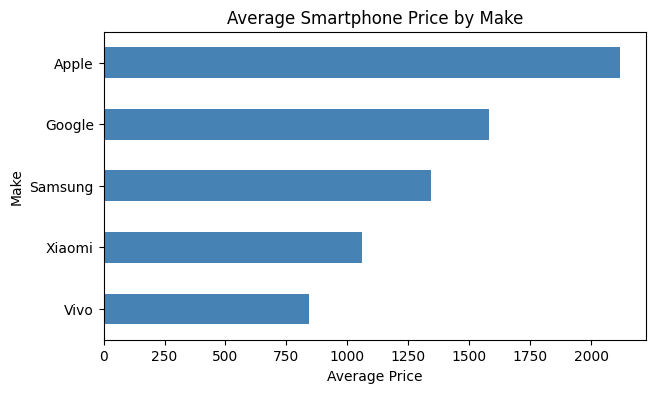


pd: <module 'pandas' from 'c:\\Users\\gell\\AppData\\Local\\anaconda3\\envs\\spenv\\Lib\\site-packages\\pandas\\__init__.py'>

plt: <module 'matplotlib.pyplot' from 'c:\\Users\\gell\\AppData\\Local\\anaconda3\\envs\\spenv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

DataFrame: data
   offer_id  dealer_plz dealer_city dealer_street_house_nr    make      model  \
0  83197857        6394  Volketswil       Blaserstrasse 19   Apple  iPhone 13   
1  36687537        9532     Oberwil        Furrerstrasse 1    Vivo   Vivo V21   
2  66722344        2227        Rüti        Maierstrasse 31    Vivo   Vivo V21   
3  56164955        5766      Bülach        Sidlerstrasse 6  Google   Pixel 6a   
4  94374605        8304        Belp       Steinerstrasse 8  Google    Pixel 6   

    price_raw camera_resolution_raw battery_life_raw storage_size_raw  \
0  CHF 2518.-                 20 MP           16 hrs           256 GB   
1   CHF 266.-                 12 MP           16 hrs           128 GB   
2   CHF 4

In [10]:
# Execute the generated Python code
local_vars = {}
figure_created = False
try:
    exec(generated_code, globals(), local_vars)
except Exception as e:
    print(f"Error executing generated code: {e}")

# Check the type of the result and display accordingly
for var_name, var_value in local_vars.items():
    if isinstance(var_value, plt.Figure):
        print(f"\nFigure: {var_name}")
        var_value.show()
        figure_created = True

if not figure_created:
    for var_name, var_value in local_vars.items():
        if isinstance(var_value, pd.DataFrame):
            print(f"\nDataFrame: {var_name}")
            print(var_value.head())
        else:
            print(f"\n{var_name}: {var_value}")